In [7]:
import pandas as pd
from datetime import date
import json

In [10]:
import os
pather=os.listdir("files/")

In [12]:
pather=["files/"+f for f in os.listdir("files/")]
pather

['files/2022-02-23',
 'files/2022-02-24',
 'files/2022-02-25',
 'files/2022-02-26',
 'files/2022-02-27',
 'files/2022-02-28',
 'files/2022-03-01',
 'files/2022-03-02',
 'files/2022-03-03',
 'files/2022-03-06',
 'files/2022-03-07',
 'files/2022-03-08',
 'files/2022-03-09']

In [14]:
def f(a):
    return pd.read_csv(a,delimiter="|",header=None,skip_blank_lines=True)
df = pd.concat(map(f, pather))

In [15]:
df

,0,1,2
0,2022-02-23 05:24:26.573953,NABIL,"{""totalBuyQty"": 4229, ""marketDepth"": {""buyMark..."
1,2022-02-23 05:24:28.992856,SCB,"{""totalBuyQty"": 5206, ""marketDepth"": {""buyMark..."
2,2022-02-23 05:24:31.423940,SBI,"{""totalBuyQty"": 1733, ""marketDepth"": {""buyMark..."
3,2022-02-23 05:24:33.729594,EBL,"{""totalBuyQty"": 13780, ""marketDepth"": {""buyMar..."
4,2022-02-23 05:24:36.292215,BOKL,"{""totalBuyQty"": 2018, ""marketDepth"": {""buyMark..."
...,...,...,...
1090,2022-03-09 09:08:22.768332,SPC,"{""totalBuyQty"": 191444, ""marketDepth"": {""buyMa..."
1091,2022-03-09 09:08:25.978560,NYADI,"{""totalBuyQty"": 7582, ""marketDepth"": {""buyMark..."
1092,2022-03-09 09:08:29.232305,MBJC,"{""totalBuyQty"": 17637, ""marketDepth"": {""buyMar..."
1093,2022-03-09 09:08:32.050919,BNHC,"{""totalBuyQty"": 5825, ""marketDepth"": {""buyMark..."


In [16]:
# df=pd.read_csv("files/20220307",delimiter="|",header=None,skip_blank_lines=True)
df.columns='a b c'.split()
df.dropna(inplace=True)
df['d']=df['c'].apply(lambda data: json.loads(data)['totalBuyQty'])
df['e']=df['c'].apply(lambda data: json.loads(data)['totalSellQty'])
df2=df.groupby("b").mean()
df2['f']=df2.d/df2.e
# df2.sort_values('f',ascending=False).head()
df2[df2['d']>1000].sort_values('f',ascending=False)

,d,e,f
b,,,
NLO,118283.850467,0.000000,inf
BNL,4737.284404,0.000000,inf
ENL,189385.619048,0.000000,inf
KEF,109664.934579,5814.878505,18.859368
SBI,16152.192661,1894.073394,8.527754
...,...,...,...
JOSHI,8974.376147,15665.348624,0.572881
CHL,3674.398148,7221.796296,0.508793
PMHPL,4083.816514,8315.880734,0.491086


<AxesSubplot:>

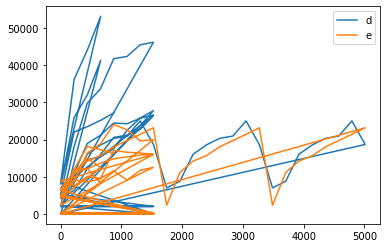

In [21]:
df[df.b=="NABIL"].plot()

In [22]:
import matplotlib.pyplot as plt

In [23]:
%% matplotlib_inline
plt.plot(df.a,[df.d,df.e])

ValueError: x and y must have same first dimension, but have shapes (23548,) and (2, 23548)

In [4]:
df2=df[df['b']=="NTC"]

In [5]:
df2

,a,b,c,d,e
62,2022-03-07 05:47:15.563986,NTC,"{""totalBuyQty"": 12512, ""marketDepth"": {""buyMar...",12512,15521
281,2022-03-07 07:02:28.563435,NTC,"{""totalBuyQty"": 16003, ""marketDepth"": {""buyMar...",16003,29481
500,2022-03-07 07:32:18.721937,NTC,"{""totalBuyQty"": 73892, ""marketDepth"": {""buyMar...",73892,16324
719,2022-03-07 08:37:26.314336,NTC,"{""totalBuyQty"": 70493, ""marketDepth"": {""buyMar...",70493,34623


In [6]:
import plotly.express  as px
px.line(df2,x='a',y='d')